# Comparing Stock Indices

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

When comparing the historical returns on stock indices, it is a common mistake to only consider a single time-period.

We will compare three well-known stock indices for USA: The S&P 500 for large-cap stocks, the S&P 400 for mid-cap stocks, and the S&P 600 for small-cap stocks. We show that there are periods where each of these stock indices was better than the others.

So a more proper way of comparing stock indices is to consider **all** investment periods. For example, instead of just comparing the returns between 1. January 1990 to 1. January 2018, we consider all 1-year investment periods between 1990 and 2018. We also consider all 2-year investment periods, 3-year periods, and so on all the way up to 10-year investment periods. We then calculate and compare various statistics to assess which stock index was best.

This methodology was also used in the paper [Comparison of U.S. Stock Indices](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2667556).

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import os

In [3]:
# Imports from FinanceOps.
from data_keys import *
from data import load_index_data, load_usa_cpi
from data import load_usa_gov_bond_1year, common_period
from returns import annualized_returns, bond_annualized_returns
from recovery import prob_recovery

## Load Data

We now load all the financial data we will be using.

In [4]:
# Define the ticker-names for the stocks we consider.
ticker_SP500 = "S&P 500"
ticker_SP400 = "S&P 400"
ticker_SP600 = "S&P 600"

# All tickers for the stocks.
tickers = [ticker_SP500, ticker_SP400, ticker_SP600]

In [5]:
# Define longer names for the stocks.
name_SP500 = "S&P 500 (Large Cap)"
name_SP400 = "S&P 400 (Mid Cap)"
name_SP600 = "S&P 600 (Small Cap)"

# All names for the stocks.
names = [name_SP500, name_SP400, name_SP600]

In [6]:
# Load the financial data for the stock indices.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_SP400 = load_index_data(ticker=ticker_SP400,
                           sales=False, book_value=False)
df_SP600 = load_index_data(ticker=ticker_SP600,
                           sales=False, book_value=False)

# All DataFrames for the stocks.
dfs = [df_SP500, df_SP400, df_SP600]

In [7]:
# Common date-range for the stocks.
start_date, end_date = common_period(dfs=dfs)
print(start_date, end_date)

1989-01-03 00:00:00 2018-07-06 00:00:00


In [8]:
# Load the US CPI inflation index.
cpi = load_usa_cpi()

In [9]:
# Load the yields for US Gov. Bonds with 1-year maturity.
bond_yields = load_usa_gov_bond_1year()

In [10]:
# Max number of investment years to consider.
num_years = 10

## Compare Total Returns

The first plot shows the so-called Total Return of the stock indices, which is the investor's return when dividends are reinvested in the same stock index and taxes are ignored.

In [11]:
def plot_total_returns(dfs, names, start_date=None, end_date=None):
    """
    Plot and compare the Total Returns for the given DataFrames.
    
    :param dfs: List of Pandas DataFrames with TOTAL_RETURN data.
    :param names: Names of the stock indices.
    :param start_date: Plot from this date.
    :param end_date: Plot to this date.
    :return: None.
    """
    
    # Create a new Pandas DataFrame which will be used
    # to combine the time-series and plot them.
    df2 = pd.DataFrame()

    # For all the given DataFrames and their names.
    for df, name in zip(dfs, names):
        # Get the Total Return for the period.
        tot_ret = df[TOTAL_RETURN][start_date:end_date]
        # Normalize it to start at 1.0
        tot_ret /= tot_ret[0]

        # Add it to the DataFrame.
        # It will be plotted with the given name.
        df2[name] = tot_ret

    # Plot it all.
    df2.plot(title="Total Return")

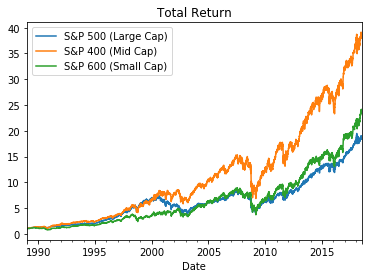

In [12]:
plot_total_returns(dfs=dfs, names=names,
                   start_date=start_date, end_date=end_date)

This plot clearly shows that the S&P 400 (Mid-Cap) had a much higher Total Return than the S&P 500 (Large-Cap) and S&P 600 (Small-Cap), and the S&P 500 performed slightly worse than the S&P 600.

But this period was nearly 30 years. What if we consider shorter investment periods with different start and end-dates? We need more detailed statistics to answer these questions.

## Calculate Annualized Returns

We calculate the annualized returns of the stock indices for **all** investment periods of durations from 1 to 10 years.

In [13]:
def calc_ann_returns(df, start_date, end_date, num_years):
    """
    Calculate the annualized returns for the Total Return
    of the given DataFrame.
    
    A list is returned so that ann_ret[0] is a Pandas Series
    with the ann.returns for 1-year periods, and ann_ret[1]
    are the ann.returns for 2-year periods, etc.
    
    :param df: Pandas DataFrame with TOTAL_RETURN data.
    :param start_date: Start-date for the data.
    :param end_date: End-date for the data.
    :return: List of Pandas Series.
    """
    
    # Get the Total Return for the given period.
    tot_ret = df[TOTAL_RETURN][start_date:end_date]
    
    # Calculate the annualized returns for all
    # investment periods between 1 and num_years.
    ann_ret = [annualized_returns(series=tot_ret, years=years)
               for years in range(1, num_years+1)]
    
    return ann_ret

In [14]:
# Annualized returns for the S&P 500.
ann_ret_SP500 = calc_ann_returns(df=df_SP500,
                                 start_date=start_date,
                                 end_date=end_date,
                                 num_years=num_years)

In [15]:
# Annualized returns for the S&P 400.
ann_ret_SP400 = calc_ann_returns(df=df_SP400,
                                 start_date=start_date,
                                 end_date=end_date,
                                 num_years=num_years)

In [16]:
# Annualized returns for the S&P 600.
ann_ret_SP600 = calc_ann_returns(df=df_SP600,
                                 start_date=start_date,
                                 end_date=end_date,
                                 num_years=num_years)

In [17]:
# Annualized returns for investing and reinvesting in
# US Gov. Bonds with 1-year maturity.
ann_ret_bond = bond_annualized_returns(df=bond_yields,
                                       num_years=num_years)

In [18]:
# Annualized returns for the US CPI inflation index.
cpi2 = cpi[start_date:end_date]
ann_ret_cpi = [annualized_returns(series=cpi2, years=i+1)
               for i in range(num_years)]

### Examples of Annualized Returns

The lists we have created above contain the annualized returns for the stock indices as well as US Government Bonds and the US CPI inflation index.

Let us show the annualized returns of the S&P 500 for all 1-year periods. This is itself a time-series. It shows that the return was about 0.347 (or 34.7%) for the year between 3. January 1989 and 3. January 1990. The return was only about 31.6% between 4. January 1989 and 4. January 1990. And so on.

In [19]:
ann_ret_SP500[0].head(10)

Date
1989-01-03    0.347433
1989-01-04    0.316132
1989-01-05    0.300592
1989-01-06    0.299486
1989-01-07    0.300960
1989-01-08    0.302432
1989-01-09    0.286608
1989-01-10    0.280842
1989-01-11    0.277912
1989-01-12    0.241273
Freq: B, Name: Total Return, dtype: float64

We can also show the summary statistics for the annualized returns of **all** 1-year periods of the S&P 500. Note that a mean of about 0.113 means an average 1-year return of 11.3%.

In [20]:
ann_ret_SP500[0].describe()

count    10412.000000
mean         0.112986
std          0.163164
min         -0.475388
25%          0.048051
50%          0.134127
75%          0.212517
max          0.725738
Name: Total Return, dtype: float64

We can also show the annualized returns of the S&P 500 for all 10-year periods. This shows that between 3. January 1989 and 1999 the annualized return was about 19.3%. Between 4. January 1989 and 1999 it was about 19.1%.

In [21]:
ann_ret_SP500[9].head(10)

Date
1989-01-03    0.192505
1989-01-04    0.190708
1989-01-05    0.192068
1989-01-06    0.194400
1989-01-07    0.194111
1989-01-08    0.194570
1989-01-09    0.194175
1989-01-10    0.194079
1989-01-11    0.193035
1989-01-12    0.190226
Freq: B, Name: Total Return, dtype: float64

These are the summary statistics for **all** 10-year periods of the S&P 500, which show that it returned about 8.2% per year on average, for **all** 10-year periods between 1989 and 2018.

In [22]:
ann_ret_SP500[9].describe()

count    7125.000000
mean        0.082307
std         0.052215
min        -0.046228
25%         0.062988
50%         0.079510
75%         0.106382
max         0.199302
Name: Total Return, dtype: float64

For US Government Bonds we only consider bonds with 1-year maturity, so for multi-year periods we assume the return is reinvested in new 1-year bonds. Reinvesting in gov. bonds gave an average return of about 5.7% for **all** 10-year periods between 1962 and 2018.

In [23]:
ann_ret_bond[9].describe()

count    17372.000000
mean         0.056716
std          0.027343
min          0.004515
25%          0.038709
50%          0.058005
75%          0.076294
max          0.104418
Name: Bond Yield, dtype: float64

## Examples of Good and Bad Periods

Using the annualized returns we have just calculated, we can now easily find investment periods where one stock index was better than another.

In [24]:
def plot_better(df1, df2, ann_ret1, ann_ret2,
                name1, name2, years):
    """
    Plot the Total Return for a period of the given number
    of years where the return on stock 1 > stock 2.

    If this does not exist, then plot for the period where
    the return of stock 1 was closest to that of stock 2.
    
    :param df1: Pandas DataFrame for stock 1.
    :param df2: Pandas DataFrame for stock 2.
    :param ann_ret1: List of ann.returns for stock 1.
    :param ann_ret2: List of ann.returns for stock 2.
    :param name1: Name of stock 1.
    :param name2: Name of stock 2.
    :param years: Investment period in years.
    :return: None.
    """

    # Convert number of years to index.
    i = years - 1

    # Difference of annualized returns.
    ann_ret_dif = ann_ret1[i] - ann_ret2[i]

    # Find the biggest return difference and use its
    # index as the start-date for the period to be plotted.
    start_date = np.argmax(ann_ret_dif)
    
    # The end-date for the period to be plotted.
    end_date = start_date + int(years * 365.25)
    
    # Create a Pandas DataFrame with stock 1,
    # whose Total Return is normalized to start at 1.0
    df = pd.DataFrame()
    tot_ret1 = df1[start_date:end_date][TOTAL_RETURN]
    df[name1] = tot_ret1 / tot_ret1[0]

    # Add stock 2 to the DataFrame.
    tot_ret2 = df2[start_date:end_date][TOTAL_RETURN]
    df[name2] = tot_ret2 / tot_ret2[0]

    # Plot the two stocks' Total Return for this period.
    df.plot(title="Total Return")

First we show a 3-year period where the S&P 500 was better than the S&P 400.

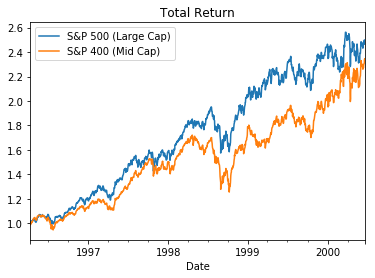

In [25]:
plot_better(df1=df_SP500, df2=df_SP400,
            ann_ret1=ann_ret_SP500,
            ann_ret2=ann_ret_SP400,
            name1=name_SP500,
            name2=name_SP400,
            years=3)

Then we show a 3-year period where the S&P 400 was better than the S&P 500.

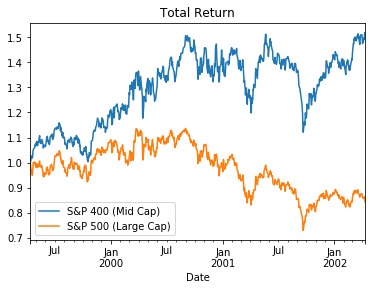

In [26]:
plot_better(df1=df_SP400, df2=df_SP500,
            ann_ret1=ann_ret_SP400,
            ann_ret2=ann_ret_SP500,
            name1=name_SP400,
            name2=name_SP500,
            years=3)

Then we show a 3-year period where the S&P 600 was better than the S&P 400.

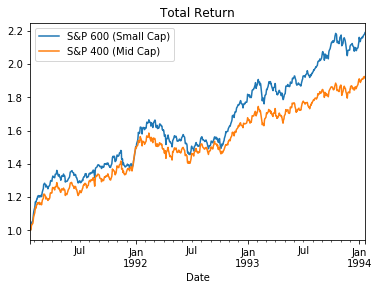

In [27]:
plot_better(df1=df_SP600, df2=df_SP400,
            ann_ret1=ann_ret_SP600,
            ann_ret2=ann_ret_SP400,
            name1=name_SP600,
            name2=name_SP400,
            years=3)

Then we show a 3-year period where the S&P 400 was better than the S&P 600.

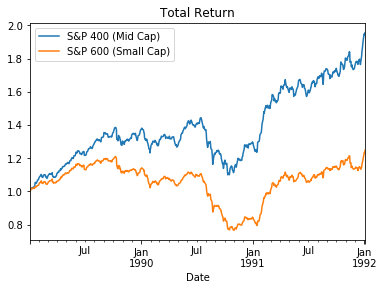

In [28]:
plot_better(df1=df_SP400, df2=df_SP600,
            ann_ret1=ann_ret_SP400,
            ann_ret2=ann_ret_SP600,
            name1=name_SP400,
            name2=name_SP600,
            years=3)

## Statistics for Annualized Returns

We can also print summary statistics for the annualized returns.

In [29]:
def print_return_stats():
    """
    Print basic statistics for the annualized returns.
    """

    # For each period-duration.
    for i in range(num_years):
        years = i + 1
        print(years, "Year Investment Periods:")

        # Create a new DataFrame.
        df = pd.DataFrame()
        
        # Add the basic statistics for each stock.
        df[name_SP500] = ann_ret_SP500[i].describe()
        df[name_SP400] = ann_ret_SP400[i].describe()
        df[name_SP600] = ann_ret_SP600[i].describe()

        # Print it.
        print(df)
        print()

When we print the summary statistics for the stock indices, we see that for 1-year investment periods the S&P 500 returned about 11.3% on average, while the S&P 400 returned about 14.0%, and the S&P 600 returned about 12.4%.

For longer investment periods the average returns decrease. For 10-year investment periods the S&P 500 returned about 8.2% per year on average, the S&P 400 returned about 11.6% on average, and the S&P 600 returned about 10.3% on average.

It can be a bit confusing to view all the summary statistics like this and it is better to show selected data in a table, as was done in the paper [Comparison of U.S. Stock Indices](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2667556).

In [30]:
print_return_stats()

1 Year Investment Periods:
       S&P 500 (Large Cap)  S&P 400 (Mid Cap)  S&P 600 (Small Cap)
count         10412.000000       10412.000000         10412.000000
mean              0.112986           0.139816             0.124422
std               0.163164           0.169569             0.182067
min              -0.475388          -0.486201            -0.480795
25%               0.048051           0.051591             0.017765
50%               0.134127           0.152299             0.138376
75%               0.212517           0.233438             0.238640
max               0.725738           0.940194             0.980847

2 Year Investment Periods:
       S&P 500 (Large Cap)  S&P 400 (Mid Cap)  S&P 600 (Small Cap)
count         10047.000000       10047.000000         10047.000000
mean              0.106581           0.132753             0.118638
std               0.127940           0.110371             0.115345
min              -0.290626          -0.292739            -0.319836
25%    

## Probability of Loss

Another useful statistic is the historical probability of loss for different investment periods.

In [31]:
def prob_loss(ann_ret):
    """
    Calculate the probability of negative ann.returns (losses).
    """

    # Remove rows with NA.
    ann_ret = ann_ret.dropna()
    
    # Calculate the probability using a boolean mask.
    mask = (ann_ret < 0.0)
    prob = np.sum(mask) / len(mask)

    return prob

In [32]:
def print_prob_loss():
    """
    Print the probability of loss for increasing investment
    periods for all the stocks.
    """

    # Create a new DataFrame.
    df = pd.DataFrame()

    # Add a column with the probability of loss for S&P 500.
    df[name_SP500] = [prob_loss(ann_ret_SP500[i])
                      for i in range(num_years)]

    # Add a column with the probability of loss for S&P 400.
    df[name_SP400] = [prob_loss(ann_ret_SP400[i])
                      for i in range(num_years)]

    # Add a column with the probability of loss for S&P 600.
    df[name_SP600] = [prob_loss(ann_ret_SP600[i])
                      for i in range(num_years)]

    # Set the index.
    df.index = ["{} Years".format(i+1) for i in range(num_years)]
    
    print(df)

This shows the probability of loss for the stock-indices for investment periods between 1 and 10 years.

For example, the S&P 500 had a loss in about 17.8% of all 1-year investment periods, while the S&P 400 had a loss in about 18.1% of all 1-year periods, and the S&P 600 had a loss in about 22.3% of all 1-year periods.

The probability of loss generally decreases as the investment period increases.

For example, the S&P 500 had a loss in about 9.6% of all 10-year investment periods, while the S&P 400 and S&P 600 did not have a loss in any of the 10-year periods.

In [33]:
print_prob_loss()

          S&P 500 (Large Cap)  S&P 400 (Mid Cap)  S&P 600 (Small Cap)
1 Years              0.178352           0.181137             0.223300
2 Years              0.174978           0.105803             0.147109
3 Years              0.189837           0.096364             0.090787
4 Years              0.230893           0.044976             0.075247
5 Years              0.174841           0.019327             0.031505
6 Years              0.049033           0.000000             0.000000
7 Years              0.027491           0.004136             0.004622
8 Years              0.051305           0.002164             0.001400
9 Years              0.065554           0.000935             0.001469
10 Years             0.096281           0.000000             0.000000


## Compared to Inflation

It is also useful to consider the probability of a stock index performing better than inflation.

In [34]:
def prob_better(ann_ret1, ann_ret2):
    """
    Calculate the probability that the ann.returns of stock 1
    were better than the ann.returns of stock 2.

    This does not assume the index-dates are identical.

    :param ann_ret1: Pandas Series with ann.returns for stock 1.
    :param ann_ret2: Pandas Series with ann.returns for stock 2.
    :return: Probability.
    """

    # Create a new DataFrame.
    df = pd.DataFrame()

    # Add the ann.returns for the two stocks.
    df["ann_ret1"] = ann_ret1
    df["ann_ret2"] = ann_ret2

    # Remove all rows with NA.
    df.dropna(inplace=True)

    # Calculate the probability using a boolean mask.
    mask = (df["ann_ret1"] > df["ann_ret2"])
    prob = np.sum(mask) / len(mask)

    return prob

In [35]:
def print_prob_better_than_inflation():
    """
    Print the probability of the stocks performing better
    than inflation for increasing investment periods.
    """
    
    # Create a new DataFrame.
    df = pd.DataFrame()

    # Add a column with the probabilities for the S&P 500.
    name = ticker_SP500 + " > CPI"
    df[name] = [prob_better(ann_ret_SP500[i], ann_ret_cpi[i])
                for i in range(num_years)]

    # Add a column with the probabilities for the S&P 400.
    name = ticker_SP400 + " > CPI"
    df[name] = [prob_better(ann_ret_SP400[i], ann_ret_cpi[i])
                for i in range(num_years)]

    # Add a column with the probabilities for the S&P 600.
    name = ticker_SP600 + " > CPI"
    df[name] = [prob_better(ann_ret_SP600[i], ann_ret_cpi[i])
                for i in range(num_years)]

    # Set the index.
    df.index = ["{} Years".format(i+1) for i in range(num_years)]
    
    print(df)

This shows the probability of each stock index having a higher return than inflation for investment periods between 1 and 10 years. All taxes are ignored.

For example, both the S&P 500 and S&P 400 had a higher return than inflation in about 79% of all 1-year investment periods, while the S&P 600 only exceeded inflation in about 73.6% of all 1-year periods.

For investment periods of 6 years or more, the S&P 400 and S&P 600 performed better than inflation for almost all investment periods. But the S&P 500 only exceeded inflation in about 86% of all 10-year periods.

In [36]:
print_prob_better_than_inflation()

          S&P 500 > CPI  S&P 400 > CPI  S&P 600 > CPI
1 Years        0.789484       0.786101       0.736033
2 Years        0.803727       0.876966       0.812945
3 Years        0.771319       0.882488       0.866889
4 Years        0.731892       0.921514       0.884432
5 Years        0.695104       0.960270       0.896455
6 Years        0.794249       0.998005       0.995305
7 Years        0.850153       0.975720       0.979277
8 Years        0.873154       0.975350       0.989087
9 Years        0.868534       0.989494       0.992726
10 Years       0.858904       0.999292       0.999292


## Compared to Bonds

It is also useful to compare the returns of the stock indices to risk-free government bonds.

In [37]:
def print_prob_better_than_bonds():
    """
    Print the probability of the stocks performing better
    than US Gov. Bonds for increasing investment periods.
    """
    
    # Create a new DataFrame.
    df = pd.DataFrame()

    # Add a column with the probabilities for the S&P 500.
    name = ticker_SP500 + " > Bonds"
    df[name] = [prob_better(ann_ret_SP500[i], ann_ret_bond[i])
                for i in range(num_years)]

    # Add a column with the probabilities for the S&P 400.
    name = ticker_SP400 + " > Bonds"
    df[name] = [prob_better(ann_ret_SP400[i], ann_ret_bond[i])
                for i in range(num_years)]

    # Add a column with the probabilities for the S&P 600.
    name = ticker_SP600 + " > Bonds"
    df[name] = [prob_better(ann_ret_SP600[i], ann_ret_bond[i])
                for i in range(num_years)]

    # Set the index.
    df.index = ["{} Years".format(i+1) for i in range(num_years)]
    
    print(df)

This shows the probability of each stock index having a higher return than risk-free government bonds, for investment periods between 1 and 10 years. We consider annual reinvestment in bonds with 1-year maturity. All taxes are ignored.

For example, the S&P 500 returned more than government bonds in about 79% of all 1-year periods, while it was 78% for the S&P 400 and 73% for the S&P 600.

For investment periods of 6 years or more, the S&P 400 and S&P 600 nearly always returned more than government bonds. But the S&P 500 only returned more than bonds in about 84% of all 10-year periods.

In [38]:
print_prob_better_than_bonds()

          S&P 500 > Bonds  S&P 400 > Bonds  S&P 600 > Bonds
1 Years          0.792451         0.782655         0.731464
2 Years          0.794864         0.867324         0.787797
3 Years          0.764925         0.869758         0.830097
4 Years          0.727458         0.896415         0.869794
5 Years          0.694448         0.942129         0.869512
6 Years          0.730608         0.996389         0.987072
7 Years          0.816567         0.974577         0.976645
8 Years          0.838956         0.965500         0.980267
9 Years          0.866489         0.970494         0.985314
10 Years         0.843789         0.997193         0.997193


## Compared to Other Stock Indices

Now we will compare the stock indices directly against each other.

In [39]:
def print_prob_better():
    """
    Print the probability of one stock index performing better
    than another stock index for increasing investment periods.
    """
    
    # Create a new DataFrame.
    df = pd.DataFrame()

    # Add a column with the probabilities for S&P 500 > S&P 400.
    name = ticker_SP500 + " > " + ticker_SP400
    df[name] = [prob_better(ann_ret_SP500[i], ann_ret_SP400[i])
                for i in range(num_years)]

    # Add a column with the probabilities for S&P 500 > S&P 600.
    name = ticker_SP500 + " > " + ticker_SP600
    df[name] = [prob_better(ann_ret_SP500[i], ann_ret_SP600[i])
                for i in range(num_years)]

    # Add a column with the probabilities for S&P 600 > S&P 400.
    name = ticker_SP600 + " > " + ticker_SP400
    df[name] = [prob_better(ann_ret_SP600[i], ann_ret_SP400[i])
                for i in range(num_years)]

    # Set the index.
    df.index = ["{} Years".format(i+1) for i in range(num_years)]
    
    print(df)  

This shows the probability of one stock index performing better than another for investment periods between 1 and 10 years. All taxes are ignored.

For example, the S&P 500 (Large-Cap) performed better than the S&P 400 (Mid-Cap) in about 42% of all 1-year periods. Similarly, the S&P 500 performed better than the S&P 600 (Small-Cap) in almost 45% of all 1-year periods.

For longer investment periods the S&P 500 generally performed worse than the S&P 400 and S&P 600. For example, the S&P 500 only performed better than the S&P 400 in about 6% of all 10-year periods, and it was better than the S&P 600 in about 15% of the 10-year periods. Similarly, the S&P 600 was better than the S&P 400 in only about 21% of all 10-year periods.

This shows that for longer investment periods the S&P 400 (Mid-Cap) mostly had a higher return than both the S&P 500 (Large-Cap) and S&P 600 (Small-Cap).

In [40]:
print_prob_better()

          S&P 500 > S&P 400  S&P 500 > S&P 600  S&P 600 > S&P 400
1 Years            0.424894           0.446024           0.495102
2 Years            0.362297           0.413656           0.518961
3 Years            0.336501           0.385561           0.516629
4 Years            0.305389           0.336840           0.485831
5 Years            0.259524           0.299631           0.458943
6 Years            0.252737           0.269509           0.411134
7 Years            0.182460           0.265175           0.302153
8 Years            0.128708           0.252451           0.239975
9 Years            0.107210           0.241522           0.181976
10 Years           0.061895           0.153123           0.210246


## Correlation

It is also useful to consider the statistical correlation between the returns of stock indices.

In [41]:
def print_correlation():
    """
    Print the correlation between the stock indices
    for increasing investment periods.
    """
    
    # Create a new DataFrame.
    df = pd.DataFrame()

    # Add a column with the correlations for S&P 500 vs. S&P 400.
    name = ticker_SP500 + " vs. " + ticker_SP400
    df[name] = [ann_ret_SP500[i].corr(ann_ret_SP400[i])
                for i in range(num_years)]

    # Add a column with the correlations for S&P 500 vs. S&P 600.
    name = ticker_SP500 + " vs. " + ticker_SP600
    df[name] = [ann_ret_SP500[i].corr(ann_ret_SP600[i])
                for i in range(num_years)]

    # Add a column with the correlations for S&P 600 vs. S&P 400.
    name = ticker_SP600 + " vs. " + ticker_SP400
    df[name] = [ann_ret_SP600[i].corr(ann_ret_SP400[i])
                for i in range(num_years)]

    # Set the index.
    df.index = ["{} Years".format(i+1) for i in range(num_years)]
    
    print(df)

This shows the correlation coefficient (Pearson) between the returns on the stock indices for investment periods between 1 and 10 years.

For example, the correlation was about 0.88 between the S&P 500 and S&P 400 for all 1-year investment periods, while it was only 0.77 for the S&P 500 and S&P 600, and 0.92 for the S&P 600 and S&P 400.

For longer investment periods the correlation coefficient generally increases. For example, the correlation was about 0.93 between the S&P 500 and S&P 400 for all 10-year investment periods, while it was about 0.85 between the S&P 500 and S&P 600, and it was almost 0.94 between the S&P 600 and S&P 400.

This shows that the return on these three stock indices are all highly correlated, so that they have a strong tendency to show losses or gains for the same periods.

It might also be useful to consider the correlation for shorter investment periods, e.g. monthly, weekly or even daily, because a low correlation between stock indices might be useful for rebalancing the investment portfolio when one stock index is down and another is up.

In [42]:
print_correlation()

          S&P 500 vs. S&P 400  S&P 500 vs. S&P 600  S&P 600 vs. S&P 400
1 Years              0.881041             0.773324             0.921980
2 Years              0.872209             0.730016             0.882637
3 Years              0.875349             0.728040             0.873453
4 Years              0.887510             0.758450             0.877225
5 Years              0.887614             0.756654             0.889081
6 Years              0.890631             0.749908             0.874440
7 Years              0.890307             0.771255             0.899970
8 Years              0.912973             0.837214             0.936627
9 Years              0.930655             0.857917             0.945555
10 Years             0.929490             0.846769             0.935134


## Recovery Times

It is also useful to consider how quickly the stock indices typically recover from losses.

In [43]:
def print_recovery_days():
    """
    Print the probability of the stocks recovering from losses
    for increasing number of days.
    """

    # Print the probability for these days.
    num_days = [7, 30, 90, 180, 365, 2*365, 5*365]
    
    # Create a new DataFrame.
    df = pd.DataFrame()
    
    # Add a column with the probabilities for the S&P 500.
    df[ticker_SP500] = prob_recovery(df=df_SP500, num_days=num_days,
                                     start_date=start_date,
                                     end_date=end_date)

    # Add a column with the probabilities for the S&P 400.
    df[ticker_SP400] = prob_recovery(df=df_SP400, num_days=num_days,
                                     start_date=start_date,
                                     end_date=end_date)

    # Add a column with the probabilities for the S&P 600.
    df[ticker_SP600] = prob_recovery(df=df_SP600, num_days=num_days,
                                     start_date=start_date,
                                     end_date=end_date)

    # Set the index.
    df.index = ["{} Days".format(days) for days in num_days]
    
    print(df)

This shows the probability that each stock index has recovered from losses within a given number of days.

For example, all three stock indices recovered from about 80-83% of all losses within just a week. The probability goes up for longer investment periods. For example, for 5-year investment periods the S&P 500 had recovered from about 99.8% of all losses, while the S&P 400 and S&P 600 had recovered from all losses in 5 years.

Note that this only measures the number of days until the stock index recovered the first time. It is possible that a stock index decreases again in the future. This can be seen from the non-zero probabilities of loss shown further above, where the S&P 400 and S&P 600 had losses in some 7, 8, and 9 year investment periods.

In [44]:
print_recovery_days()

            S&P 500   S&P 400   S&P 600
7 Days     0.826761  0.814791  0.804398
30 Days    0.938016  0.931985  0.921128
90 Days    0.975503  0.968915  0.962698
180 Days   0.984411  0.984597  0.982370
365 Days   0.988865  0.994340  0.991278
730 Days   0.992113  0.999165  0.998423
1825 Days  0.997773  1.000000  1.000000


## Discussion

From the above statistics we saw that the S&P 400 (Mid-Cap) was generally better than the S&P 600 (Small-Cap), which was generally better than the S&P 500 (Large-Cap), especially for longer investment periods.

For all 10-year investment periods between 1989 and 2018, the S&P 400 returned 11.6% per year on average, while the S&P 600 returned 10.3% on average, and the S&P 500 only returned 8.2% on average.

Furthermore, the S&P 400 and 600 almost never had losses for investment periods of 6 years or more, while the S&P 500 had losses in about 9.6% of all 10-year investment periods.

Obviously the S&P 400 (Mid-Cap) would have been a better investment for most longer periods between 1989 and 2018. The question is whether this superiority will continue in the future?

### Forecasting Future Returns

It is easy to imagine, that if many investors were to believe that the S&P 400 was generally a superior investment to the S&P 500, then the price of the S&P 400 would be bid up to the point where its future earnings growth could no longer justify its price and the S&P 400 would therefore end up under-performing the S&P 500 in the long-term.

We therefore need to forecast the future returns of the S&P 400 and S&P 600 similarly to how we did that for the S&P 500 in the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb). The problem is that we do not have the P/Sales or P/Book data for the S&P 400 and S&P 600. This data can be purchased from Standard & Poor's but it is quite expensive.

What we have instead are the dividend payouts for the S&P 400 and 600, which can be used to calculate the P/Dividend ratio or its reciprocal value called the Dividend Yield. You are encouraged to try and run the previous Python Notebook with this data to see if you can forecast the future returns of the S&P 400 and 600 from their dividend yields.

Once you have forecasted the future returns of the three indices you can guage whether the indices are mispriced, so that one index might currently be preferred over the others.

### Cause of Growth

We have not considered the underlying cause of growth for these three indices. It would be of great importance to know whether the superior returns on the S&P 400 were caused by superior growth in sales and earnings, and whether we might expect such growth to continue in the future. More detailed financial data is needed for this analysis, which unfortunately can be difficult and expensive to obtain for many stock indices.

## License (MIT)

Copyright (c) 2015-18 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.